In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy.stats

Often, doctors have to make diagnoses on the basis of qualitative information, and have only a fuzzy idea of how confident they should be in their judgements. Even when you are sick and want to know what specific illness you have (and how to treat it), the best you can find on the internet is usually qualitative descriptions of diseases and their symptoms that give you few means to quantify your confidence that you have a given disease.

I have always thought that medical practice would benefit from a greater emphasis on numbers. It would be extremely useful if we could just take a person's health profile and calculate their risk for various diseases. Given the right dataset, this is very simple to do. To that end, I think it would be interesting and useful to try to predict the risk of getting a certain disease given patient characteristics. I will create a model to predict whether a person has heart disease from a [public dataset](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) I retrieved from Kaggle.

# Data Cleaning and Exploratory Analysis

In [7]:
#Import data
df = pd.read_csv('heart_2020_cleaned.csv', encoding = "ISO-8859-1")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [8]:
df.GenHealth.unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

In [9]:
#Change all Yes/No variables to binary 1/0 values
yes_no_names = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'DiffWalking','Diabetic', 'PhysicalActivity',
       'Asthma', 'KidneyDisease', 'SkinCancer']

for i in yes_no_names:
    df[i] = [0 if df[i][j]=='No' else 1 for j in range(df[i].size)]

df[yes_no_names]

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Diabetic,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
0,0,1,0,0,0,1,1,1,0,1
1,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,0,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
319790,1,1,0,0,1,1,0,1,0,0
319791,0,1,0,0,0,0,1,1,0,0
319792,0,0,0,0,0,0,1,0,0,0
319793,0,0,0,0,0,0,0,0,0,0


In [10]:
#Convert GenHealth into binary category
# df.GenHealth = [0 if (df.GenHealth[j]=='Poor') or (df.GenHealth[j]=='Fair') else 1 for j in range(df.GenHealth.size)]

df.GenHealth = [1 if (df.GenHealth[j]=='Excellent') else 0 for j in range(df.GenHealth.size)]

<AxesSubplot:>

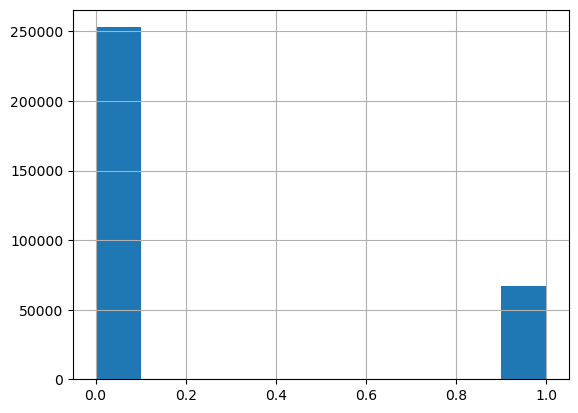

In [11]:
df.GenHealth.hist()

In [12]:
#Check if any of the features contain NaNs and require imputing
for Feature in df.columns:
    print(np.nan in df[Feature].unique())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Looks like no NaNs! That's what I like to see.

## Effect of BMI on Heart Disease Risk

It is common knowledge that BMI predicts heart disease risk, but it would be interesting to see whether this relationship still holds if you compare only physically healthy obese and non-obese people. A simple way to check this with our dataset is to use the PhysicalHealth variable to disaggregate the data and then look at heart disease risk ratio for people in the groups above and below a BMI cutoff. [According to the CDC](https://www.cdc.gov/obesity/basics/adult-defining.html), BMI below 18.5 is underweight, 18.5 - 25.0 is healthy weight, and 25.0 - 30.0 is overweight, and greater than 30.0 is obese. Let's see how the groups compare.

In [104]:
#Make the categorized datasets
df_underweight = df.copy()[df.BMI <= 18.5]

df_healthy_weight = df.copy()[(18.5 < df.BMI) & (df.BMI <= 25.0)]

df_overweight = df.copy()[(25.0 < df.BMI) & (df.BMI <= 30.0)]

df_obese = df.copy()[30.0 < df.BMI]

print('Raw heart disease risk by weight category')
print('Underweight heart disease risk: {}% +/- {}%'.format(round(100*df_underweight.HeartDisease.mean(),3),round(df_underweight.HeartDisease.std()/np.sqrt(df_underweight.HeartDisease.shape[0])*100,2)))
print('Healthy weight heart disease risk: {}% +/- {}%'.format(round(100*df_healthy_weight.HeartDisease.mean(),3),round(df_healthy_weight.HeartDisease.std()/np.sqrt(df_healthy_weight.HeartDisease.shape[0])*100,2)))
print('Overweight heart disease risk: {}% +/- {}%'.format(round(100*df_overweight.HeartDisease.mean(),3),round(df_overweight.HeartDisease.std()/np.sqrt(df_overweight.HeartDisease.shape[0])*100,2)))
print('Obese heart disease risk: {}% +/- {}%'.format(round(100*df_obese.HeartDisease.mean(),3),round(df_obese.HeartDisease.std()/np.sqrt(df_obese.HeartDisease.shape[0])*100,2)))

healthy_risk = df_healthy_weight.HeartDisease.mean()
obese_risk = df_obese.HeartDisease.mean()

healthy_risk_uncertainty = df_healthy_weight.HeartDisease.std()/np.sqrt(df_healthy_weight.HeartDisease.shape[0])
obese_risk_uncertainty = df_obese.HeartDisease.std()/np.sqrt(df_obese.HeartDisease.shape[0])

#Caclulate uncertainty of risk ratio using standard errors and error propagation
ΔRR = np.sqrt((1/healthy_risk*obese_risk_uncertainty)**2 + ((obese_risk/healthy_risk)**2*healthy_risk_uncertainty)**2)

print('Obesity / healthy weight heart disease risk ratio: {} +/- {}'.format(round(df_obese.HeartDisease.mean()/\
                                                                     (df_healthy_weight.HeartDisease.mean()),3),round(ΔRR,3)))

#Two-sample, two-tail t-test; null hypothesis is μ1 = μ2
t_stat = round((df_obese.HeartDisease.mean()-df_healthy_weight.HeartDisease.mean())/\
            np.sqrt(df_obese.HeartDisease.std()**2/df_obese.HeartDisease.shape[0]+\
                    df_healthy_weight.HeartDisease.std()**2/df_healthy_weight.HeartDisease.shape[0]),3)

print('Obesity - healthy weight heart disease risk mean difference t-statistic: {}'.format(t_stat))
print('p value: {}'.format(scipy.stats.t.sf(t_stat, df=(df_healthy_weight.HeartDisease.shape[0]+\
                                                        df_obese.HeartDisease.shape[0] - 2))))

Raw heart disease risk by weight category
Underweight heart disease risk: 7.841% +/- 0.38%
Healthy weight heart disease risk: 6.483% +/- 0.08%
Overweight heart disease risk: 8.74% +/- 0.08%
Obese heart disease risk: 10.374% +/- 0.1%
Obesity / healthy weight heart disease risk ratio: 1.6 +/- 0.015
Obesity - healthy weight heart disease risk mean difference t-statistic: 31.488
p value: 2.158934103688081e-217


In [105]:
len(df_obese.HeartDisease)

102548

In [106]:
#Make the categorized datasets, fixing GenHealthy to 1
df_underweight = df.copy()[(df.BMI <= 18.5) & (df.GenHealth==1)]

df_healthy_weight = df.copy()[(18.5 < df.BMI) & (df.BMI <= 25.0) & (df.GenHealth==1)]

df_overweight = df.copy()[(25.0 < df.BMI) & (df.BMI <= 30.0) & (df.GenHealth==1)]

df_obese = df.copy()[(30.0 < df.BMI) & (df.GenHealth==1)] 

print('Raw heart disease risk by weight category (physically healthy people only)')
print('Underweight heart disease risk: {}% +/- {}%'.format(round(100*df_underweight.HeartDisease.mean(),3),round(df_underweight.HeartDisease.std()/np.sqrt(df_underweight.HeartDisease.shape[0])*100,2)))
print('Healthy weight heart disease risk: {}% +/- {}%'.format(round(100*df_healthy_weight.HeartDisease.mean(),3),round(df_healthy_weight.HeartDisease.std()/np.sqrt(df_healthy_weight.HeartDisease.shape[0])*100,2)))
print('Overweight heart disease risk: {}% +/- {}%'.format(round(100*df_overweight.HeartDisease.mean(),3),round(df_overweight.HeartDisease.std()/np.sqrt(df_overweight.HeartDisease.shape[0])*100,2)))
print('Obese heart disease risk: {}% +/- {}%'.format(round(100*df_obese.HeartDisease.mean(),3),round(df_obese.HeartDisease.std()/np.sqrt(df_obese.HeartDisease.shape[0])*100,2)))

healthy_risk = df_healthy_weight.HeartDisease.mean()
obese_risk = df_obese.HeartDisease.mean()

healthy_risk_uncertainty = df_healthy_weight.HeartDisease.std()/np.sqrt(df_healthy_weight.HeartDisease.shape[0])
obese_risk_uncertainty = df_obese.HeartDisease.std()/np.sqrt(df_obese.HeartDisease.shape[0])

#Caclulate uncertainty of risk ratio using standard errors and error propagation
ΔRR = np.sqrt((1/healthy_risk*obese_risk_uncertainty)**2 + ((obese_risk/healthy_risk)**2*healthy_risk_uncertainty)**2)

print('Obesity / healthy weight heart disease risk ratio: {} +/- {}'.format(round(df_obese.HeartDisease.mean()/\
                                                                     (df_healthy_weight.HeartDisease.mean()),3),round(ΔRR,3)))

#Two-sample, two-tail t-test; null hypothesis is μ1 = μ2
t_stat = round((df_obese.HeartDisease.mean()-df_healthy_weight.HeartDisease.mean())/\
            np.sqrt(df_obese.HeartDisease.std()**2/df_obese.HeartDisease.shape[0]+\
                    df_healthy_weight.HeartDisease.std()**2/df_healthy_weight.HeartDisease.shape[0]),3)

print('Obesity - healthy weight heart disease risk mean difference t-statistic: {}'.format(t_stat))
print('p value: {}'.format(scipy.stats.t.sf(t_stat, df=(df_healthy_weight.HeartDisease.shape[0]+\
                                                        df_obese.HeartDisease.shape[0] - 2))))

Raw heart disease risk by weight category (physically healthy people only)
Underweight heart disease risk: 1.632% +/- 0.37%
Healthy weight heart disease risk: 1.646% +/- 0.07%
Overweight heart disease risk: 2.626% +/- 0.1%
Obese heart disease risk: 3.017% +/- 0.16%
Obesity / healthy weight heart disease risk ratio: 1.833 +/- 0.097
Obesity - healthy weight heart disease risk mean difference t-statistic: 7.766
p value: 4.144386570164953e-15


The risk ratio suggests that obese people are indeed at higher risk for heart disease, and this is true in both categories. The p value is extremely small in both cases, meaning we can reject the null hypothesis (that healthy BMI and obese people have the same heart disease risk) without hesitation.

Interestingly, if we compare the risk ratios for all obese and healthy weight people to just those obese and healthy weight people in 'Excellent' general health, we find that the ratio is *higher* for the latter category!

Why might that be? Maybe the self assessments of people's health at the tails of the BMI distribution are relatively over-optimistic. Or perhaps the average healthy weight person takes greater risks with their health in other areas than the average obese person does. This latter question is something we can at least partially address with the data by checking smoking rates for each group. I will do this now by calculating the mean smoking rate (and corresponding standard error) for each group in the general population.

In [107]:
#Compare smoking rates between healthy weight and obese people
df_healthy_weight = df.copy()[(18.5 < df.BMI) & (df.BMI <= 25.0)]

df_obese = df.copy()[30.0 < df.BMI]

print('Smoking rates among obese people: {}% +/- {}%'.format(round(df_healthy_weight.Smoking.mean()*100,3),round(df_healthy_weight.Smoking.std()/np.sqrt(df_healthy_weight.shape[0]),4)))
print('Smoking rates among obese people: {}% +/- {}%'.format(round(df_obese.Smoking.mean()*100,3),round(df_obese.Smoking.std()/np.sqrt(df_obese.shape[0]),4)))

#Two-sample, two-tail t-test; null hypothesis is μ1 = μ2
t_stat = round((df_obese.Smoking.mean()-df_healthy_weight.Smoking.mean())/\
            np.sqrt(df_obese.Smoking.std()**2/df_obese.Smoking.shape[0]+\
                    df_healthy_weight.Smoking.std()**2/df_healthy_weight.Smoking.shape[0]),3)

print('Obesity - healthy weight smoking mean difference t-statistic: {}'.format(t_stat))
print('p value: {}'.format(scipy.stats.t.sf(t_stat, df=(df_healthy_weight.Smoking.shape[0]+\
                                                        df_obese.Smoking.shape[0] - 2))))

Smoking rates among obese people: 38.762% +/- 0.0016%
Smoking rates among obese people: 42.642% +/- 0.0015%
Obesity - healthy weight smoking mean difference t-statistic: 17.687
p value: 2.9856410125603523e-70


It turns out that obese people actually smoke at statistically significantly higher rates than healthy weight people, so my second explanation above does not hold water! So for now, it is still unclear why the heart disease risk ratio would be higher in the physically healthy subset of the data. 

In any case, the data do provide strong evidence that we are justified in rejecting the null hypothesis. Being overweight or obese is still a heart disease risk independent of general health level.

# Correlations Among the Features
Moving on, I will plot the correlation matrix to get an idea of how the features relate to each other.

In [17]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
HeartDisease,1.000000,0.051803,0.107764,-0.032080,0.196835,0.170721,0.028591,0.201258,0.170977,-0.100030,-0.116042,0.008327,0.041444,0.145197,0.093317
BMI,0.051803,1.000000,0.023118,-0.038816,0.019733,0.109788,0.064131,0.181678,0.208232,-0.150616,-0.179993,-0.051822,0.092345,0.050768,-0.033644
Smoking,0.107764,0.023118,1.000000,0.111768,0.061226,0.115352,0.085157,0.120074,0.055127,-0.097174,-0.117444,-0.030336,0.024149,0.034920,0.033977
AlcoholDrinking,-0.032080,-0.038816,0.111768,1.000000,-0.019858,-0.017254,0.051282,-0.035328,-0.057644,0.017487,0.015578,-0.005065,-0.002202,-0.028280,-0.005702
Stroke,0.196835,0.019733,0.061226,-0.019858,1.000000,0.137014,0.046467,0.174143,0.102787,-0.079455,-0.073916,0.011900,0.038866,0.091167,0.048116
PhysicalHealth,0.170721,0.109788,0.115352,-0.017254,0.137014,1.000000,0.287987,0.428373,0.153469,-0.232283,-0.173037,-0.061387,0.117907,0.142197,0.041700
MentalHealth,0.028591,0.064131,0.085157,0.051282,0.046467,0.287987,1.000000,0.152235,0.032353,-0.095808,-0.111877,-0.119717,0.114008,0.037281,-0.033412
DiffWalking,0.201258,0.181678,0.120074,-0.035328,0.174143,0.428373,0.152235,1.000000,0.209640,-0.278524,-0.173606,-0.022216,0.103222,0.153064,0.064840
Diabetic,0.170977,0.208232,0.055127,-0.057644,0.102787,0.153469,0.032353,0.209640,1.000000,-0.135451,-0.155043,0.000494,0.050782,0.142371,0.034473
PhysicalActivity,-0.100030,-0.150616,-0.097174,0.017487,-0.079455,-0.232283,-0.095808,-0.278524,-0.135451,1.000000,0.137030,0.003849,-0.041526,-0.081827,-0.001328


Most of the variables have weak correlations with one another, which is good for avoiding multicollinearity, at least. The two strongest correlations are 0.43 between difficulty walking and physical health and 0.29 between physical health and mental health. As for predicting heart disease, the strongest correlates are difficulty walking at 0.20, diabetes at 0.17, and physical health at 0.17.

# Logit Model of Heart Disease
OK, now I will try making a model to predict HeartDisease. We'll go with logistic regression. However, before I begin modeling, I want to note something about the data:

In [41]:
df.HeartDisease.value_counts()

0    292422
1     27373
Name: HeartDisease, dtype: int64

People with no reported heart disease are about 90% of the dataset. In a preliminary model, I just tried to predict heart disease using this raw data, and obtained an precision of about 90%. But that is only because the logit model was classifying everyone as not having heart disease! The predictions were riddled with false negatives, and false negatives are exactly the sort of error you don't want when it comes to heart disease. To solve this problem, I will balance the dataset by downsampling the negative class.

In [28]:
"""Fresh dataframe"""
df_r = pd.read_csv('heart_2020_cleaned.csv', encoding = "ISO-8859-1")
df_r

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [31]:
df_r[df_r['HeartDisease']=='Yes'].shape[0]

27373

In [32]:
"""Train-test split"""
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
df_majority = df_r[df_r['HeartDisease']=='No']
df_minority = df_r[df_r['HeartDisease']=='Yes']

#Downsample majority class
df_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=len(df_minority.index),    
                                 random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_downsampled, df_minority])

X_data = df_downsampled.copy().drop(columns=['HeartDisease'])
y_data = df_downsampled.copy()['HeartDisease']

#Make HeartDisease a boolean variable
y_data = pd.DataFrame([0 if y_data[j]=='No' else 1 for j in y_data.index])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [33]:
df_downsampled.HeartDisease.value_counts()

No     27373
Yes    27373
Name: HeartDisease, dtype: int64

In [34]:
df_r.select_dtypes(exclude=["number","bool_"]).columns

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

#Make preprocessing pipeline for data. We want to one hot encode categorical columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('OH', OneHotEncoder(handle_unknown='ignore'), ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'])
    ])

In [78]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

#Build model
#model = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
#             early_stopping_rounds=5, 
#             eval_set=[(X_bench_test, y_bench_test)],
#             verbose=False);

model = LogisticRegression()

heart_disease_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                              ]);

#Train model
heart_disease_pipeline.fit(X_train, y_train)

C:\Users\phyis\miniconda3\envs\phd_env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OH',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('model', LogisticRegression())])

In [81]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Predict best bench lifts for test set
heart_disease_preds = heart_disease_pipeline.predict(X_test);

#Check model performance
heart_disease_precision_score = precision_score(y_test, heart_disease_preds);
heart_disease_recall_score = recall_score(y_test, heart_disease_preds);

#Check F1 score
from sklearn.metrics import f1_score
heart_disease_F1 = f1_score(y_test, heart_disease_preds)

print('Precision: {}% \n'.format(round(heart_disease_pipeline.score(X_test, y_test)*100,1)))
print('Recall: {}% \n'.format(round(heart_disease_recall_score*100,1)))
print('F1 score: %s \n' % round(heart_disease_F1,2))

#Print the confusion matrix
cm = metrics.confusion_matrix(y_test, heart_disease_preds)
print('Confusion matrix: \n',cm)

Precision: 76.6% 

Recall: 78.5% 

F1 score: 0.77 

Confusion matrix: 
 [[4067 1374]
 [1186 4323]]


The model obtains 76.6% accuracy! Additionally, judging by the precision and recall, the F1 score, and the confusion matrix, we are striking a good balance between Type I and Type II errors. Realistically, however, we would probably want to lower false negatives a more than false positives, since it is far worse to have heart disease and not know than to think you have it and not!

In any case, I think we have produced a solid model for predicting heart disease risk. I have tried to improve the results by trying out different models, such as a decision tree classifier or XGBoost, but logistic regression outperformed both. At this point, I think it will be difficult to improve on this model with this data. Perhaps I could gain some ground with feature engineering. In any case, I do think we could tweak the model depending on the desired application. For example, if we wanted to use the model to tell people whether they should consult with their doctor about heart disease risk, we might want to be more conservative and lower the threshold for classifying someone as having heart disease with this model.

Overall, I'm quite pleased with this model, and hope that it serves as an example of a disease risk calculator which I think should enjoy more widespread use in the medical industry.